In [1]:
import numpy as np
import cvxpy as cp

from qutip import coherent, ket2dm, Qobj, expect, fidelity, fock, fock_dm, displace, coherent_dm, qeye, squeeze
from qutip.visualization import plot_wigner_fock_distribution, plot_fock_distribution
from qutip.wigner import qfunc

from tqdm.auto import tqdm # progress bar

import matplotlib.pyplot as plt
from joblib import Parallel, delayed

### Define Q-function measurement operators

In [2]:
def qfunc_ops(hilbert_size, beta):
    
    # need the larger Hilbert space to not get erroneous operators for large beta
    op = coherent_dm(hilbert_size*4, beta)/np.pi
    op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        
    return op

### Define a state $\rho$ to test the tomography on

In [3]:
# Fock space dimension
N = 10

# different test states
# Fock
#state = fock(N,1)

# Binomial
state = (fock(N,0) + fock(N,4)).unit()

# Squeezed vacuum
#state = squeeze(N,1)*fock(N,0)

# calculate Q-function
lim=2.75
nsteps = 500
xvec0 = np.linspace(-lim,lim,nsteps)
yvec0=np.linspace(-lim,lim,nsteps)

Q = qfunc(state, xvec0, yvec0, g=2)

### Sample from Q-function to get heterodyne histogram

In [4]:
# number of samples
nr_samples = 50000

# number of histogram bins 
nbins = 20

# Create a flat copy of the array, normalize in order to use numpy.random.choice
Q_flat = Q.flatten() / np.sum(Q.flatten())


def get_sample(random_state):
    # generate "determinisic" random state for reproducibility
    rng = np.random.RandomState(random_state)
    
    # sample an index from the 1D array with the
    # probability distribution from the original array  
    sample_index = rng.choice(a=Q_flat.size, p=Q_flat)

    adjusted_index = np.unravel_index(sample_index, Q.shape)

    # x and y-coordinates
    idx = adjusted_index[0]
    idy = adjusted_index[1]
    
    # scale to phase space coordinates instead of indices
    X = -lim + idx*lim/(nsteps/2)
    Y = -lim + idy*lim/(nsteps/2)
    
    return X,Y

# generate "deterministic" seeds for reproducibility
np.random.seed(100)
random_seeds = np.random.randint(1000000, size=nr_samples)

samples = Parallel(n_jobs=-2,verbose=5)(delayed(get_sample)(rng) for rng in random_seeds)

X = np.array(samples)[:,0]
Y = np.array(samples)[:,1]

# bin and create histogram
sampled_Q, xedges, yedges = np.histogram2d(X,Y,bins=nbins, normed=True)

xvec1 = xedges
yvec1 = yedges

# Use midpoint of grid as phase space points
xvec = []
for idx, x in enumerate(xvec1[:-1]):
    xvec.append((x + xvec1[idx+1])/2)

yvec = []
for idx, y in enumerate(yvec1[:-1]):
    yvec.append((y + yvec1[idx+1])/2)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 31 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-2)]: Done 107 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-2)]: Done 537 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-2)]: Done 2705 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-2)]: Done 5873 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-2)]: Done 9617 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-2)]: Done 13937 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-2)]: Done 18833 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-2)]: Done 24305 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-2)]: Done 30353 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-2)]: Done 36977 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-2)]: Done 44177 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-2)]: Done 49718 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-2)]: Done 50000 out of 50000 | elapsed:   16.4s finished


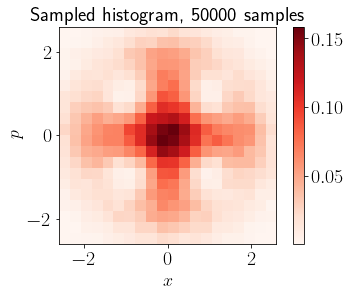

In [5]:
plt.imshow(sampled_Q,extent=[min(xvec), max(xvec),min(yvec), max(yvec)],cmap=plt.cm.Reds)
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$p$')

plt.title("Sampled histogram, %d samples"%(nr_samples));

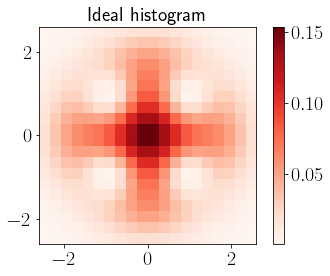

In [6]:
# compare with infinite samples
Q = qfunc(state, xvec, yvec, g=2)

plt.imshow(Q,extent=[min(xvec), max(xvec),min(yvec), max(yvec)], cmap=plt.cm.Reds)
plt.title("Ideal histogram");
plt.colorbar();

### Measurement settings

In [7]:
X, Y = np.meshgrid(xvec, yvec)

# flatten the grid into a 1D array
betas = (X + 1j*Y).ravel()

#### Assign measurement operators $\Pi$ with the measurement settings

In [8]:
Pis = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(qfunc_ops)(N,beta) for beta in betas)

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  40 tasks      | elapsed:    1.5s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    5.6s
[Parallel(n_jobs=16)]: Done 256 tasks      | elapsed:   10.5s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:   15.3s finished


### Set measurement data to histogram, and compare with ideal values

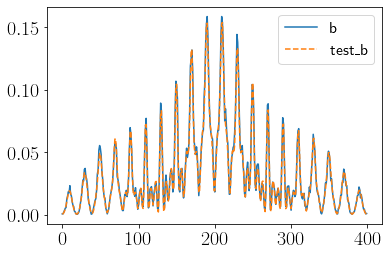

In [9]:
b = sampled_Q.flatten()

test_b = expect(Pis, state)
test_b = np.array(test_b)

plt.plot(b, label='b')
plt.plot(test_b,'--', label='test_b')
plt.legend();

# CVX

### Construct the operator basis: Fock basis
The list `basis_dms` contains all $\Omega_k$

In [10]:
# construct vectors
basis_vectors = []
for i in range(N):
    vector = fock(N, i)
    basis_vectors.append(np.real(vector.full()))
    
# construct operators
basis_dms = []
for vector1 in basis_vectors:
    for vector2 in basis_vectors:
        dm = np.outer(vector1, vector2)
        basis_dms.append(dm)

### Construct the matrix A in $A\vec\rho=\vec b$
From `Pis` and `basis_dms`.

In [11]:
def func(index, a):
    return np.trace(Pis[index[0]].full() @ basis_dms[index[1]])

A = np.zeros((len(Pis), N*N), dtype=np.complex64)
A_p = Parallel(n_jobs=16, verbose=5, backend="multiprocessing")(delayed(func)(idx,a) for idx, a in np.ndenumerate(A))

A = np.reshape(A_p, (len(Pis), N*N))

[Parallel(n_jobs=16)]: Using backend MultiprocessingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  48 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 512 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 8160 tasks      | elapsed:    0.3s
[Parallel(n_jobs=16)]: Done 37146 tasks      | elapsed:    0.7s
[Parallel(n_jobs=16)]: Done 40000 out of 40000 | elapsed:    0.8s finished


In [12]:
np.shape(A), np.shape(b)

((400, 100), (400,))

## Convex optimization

Define the unknown state as a $N\times N$ Hermitian matrix

In [13]:
X = cp.Variable((N,N), hermitian=True)

#Set the cost function to $\|A\vec\rho - \vec b\|_2$ where the vectorized state is given by `cp.vec(X)`.

cost = cp.norm(A @ cp.vec(X) - b, 2);

#Set the trace constraint and positive-semidefinite constraint, respectively.

constraints = [cp.trace(X) == 1, X >> 0 ]

#Set up and solve the problem!

prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve();

# Assign the optimized state X to a Qobj.

reconstructed_rho = Qobj(X.value)

### Visualize results

Plot the reconstructed state and show the fidelity

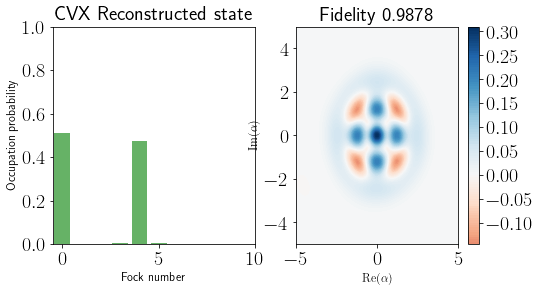

In [14]:
fig, ax = plot_wigner_fock_distribution(reconstructed_rho, alpha_max=5, colorbar=True)
ax[0].set_title("CVX Reconstructed state");
f_cvx = fidelity(reconstructed_rho, state)
ax[1].set_title("Fidelity {:.4}".format(f_cvx));

# MLE

In [15]:
fidelities = []
max_iterations = 10000

# variable names were different in this code
data = b
hilbert_size = N
rho_true = state
m_ops = Pis

ops_numpy = [op.full() for op in m_ops]

rho = qeye(hilbert_size)/hilbert_size
fidelities.append(fidelity(rho_true, rho))
pbar = tqdm(range(max_iterations))


for i in range(max_iterations):
    guessed_val = expect(m_ops, rho)
    ratio = data / guessed_val
    rho_old = rho

    R = Qobj(np.einsum("aij,a->ij", ops_numpy, ratio))
    rho = R * rho * R
    rho = rho / rho.tr()

    f = fidelity(rho, rho_true)
    fidelities.append(f)
    
    diff_rho = rho-rho_old
    diff_norm = np.sqrt(np.trace(diff_rho*diff_rho.dag())).real
    if diff_norm < 1e-6:
               break

    pbar.set_description("Fidelity iMLE {:.4f}, diff norm {:.2e}".format(f, diff_norm))
    pbar.update()

  0%|          | 0/10000 [00:00<?, ?it/s]

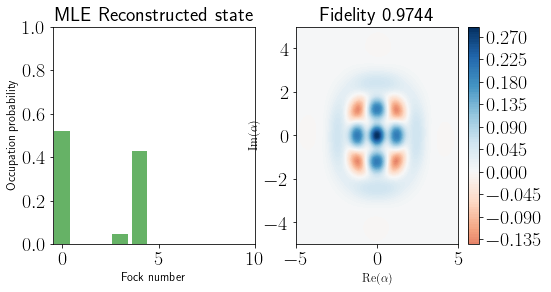

In [16]:
fig, ax = plot_wigner_fock_distribution(rho, alpha_max=5, colorbar=True)
ax[0].set_title("MLE Reconstructed state");
f_mle = fidelity(rho, state)
ax[1].set_title("Fidelity {:.4}".format(f_mle));